In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns 
import scanpy as sc
import scipy as sp
import numpy as np
import anndata
import json
import base64
import zlib
from adjustText import adjust_text
import loompy as lp
from scipy import stats
from sklearn.metrics import cohen_kappa_score
import matplotlib.pyplot as pl
from matplotlib import rcParams
import pyscenic
from collections import Counter
from pyscenic.utils import load_motifs
from pyscenic.transform import df2regulons
sc.settings.verbosity = 3 
sc.logging.print_header()


scanpy==1.8.1 anndata==0.8.0 umap==0.5.1 numpy==1.21.2 scipy==1.7.0 pandas==1.3.0 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.9.6 pynndescent==0.5.4


In [4]:
!pyscenic ctx \
grnDF_epoch_pearson_pt_0715_4757hvg.csv \
hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.feather \
--annotations_fname motifs-v9-nr.hgnc-m0.001-o0.0.tbl \
--expression_mtx_fname pt_07152022_4757hvg.loom \
--mode "dask_multiprocessing" \
--output reg_run_4757.csv \
--num_workers 20 \
--mask_dropouts


2022-08-05 12:36:08,197 - pyscenic.cli.pyscenic - INFO - Creating modules.

2022-08-05 12:36:08,228 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2022-08-05 12:36:11,747 - pyscenic.utils - INFO - Calculating Pearson correlations.

2022-08-05 12:36:11,769 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [True].

2022-08-05 12:36:14,048 - pyscenic.utils - INFO - Creating modules.

2022-08-05 12:36:41,326 - pyscenic.cli.pyscenic - IN

[########                                ] | 20% Completed |  6min 30.8s
2022-08-05 12:43:13,228 - pyscenic.transform - WARNING - Less than 80% of the genes in AC092835.1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.
[########                                ] | 20% Completed |  6min 41.3s
2022-08-05 12:43:23,822 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MBD4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.
[########                                ] | 20% Completed |  6min 53.7s
2022-08-05 12:43:36,133 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR1I3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.
[########                                ] | 20% Completed |  7min 30.1s
2022-08-05 12:44:12,627 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ST18 could be mapped to hg38__refseq-r80_

In [7]:
!pyscenic aucell \
pt_07152022_4757hvg.loom \
reg_run_4757.csv \
--output regulon_pt_07152022_4757hvg.loom \
--num_workers 20


2022-08-05 12:53:06,091 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2022-08-05 12:53:07,953 - pyscenic.cli.pyscenic - INFO - Loading gene signatures.
Create regulons from a dataframe of enriched features.
Additional columns saved: []

2022-08-05 12:53:09,408 - pyscenic.cli.pyscenic - INFO - Calculating cellular enrichment.

2022-08-05 12:53:35,180 - pyscenic.cli.pyscenic - INFO - Writing results to file.


In [8]:
from collections import Counter
from pyscenic.utils import load_motifs
from pyscenic.transform import df2regulons

In [9]:
motifs =[]
motifs.append(load_motifs('reg_run_4757.csv'))

In [10]:
regulons = []
for regulons_l in map(df2regulons, motifs):
    single = None
    for r in regulons_l:
        ks = []
        for k, v in r.gene2weight.items():
            ks += [k]
        single = pd.concat([single, pd.DataFrame({r.name: ks})], axis=1)
    regulons.append(single.fillna(''))

Create regulons from a dataframe of enriched features.
Additional columns saved: []


In [11]:
pd.DataFrame(regulons[0]).to_csv("regulon_4757.csv")

In [12]:
from pyscenic.rss import regulon_specificity_scores
from pyscenic.plotting import plot_rss
import matplotlib.pyplot as plt
import seaborn as sns
from pyscenic.binarization import binarize

In [13]:
lf = lp.connect("regulon_pt_07152022_4757hvg.loom", mode='r', validate=False )

In [14]:
exprMat = pd.DataFrame( lf[:,:], index=lf.ra.Gene, columns=lf.ca.CellID).T
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)

In [16]:
pt=sc.read_h5ad("pt_07152022_4757hvg.h5ad")

In [17]:
celltype=pd.DataFrame(pt.obs['cluster.l1'])

In [18]:
predict={"PT.S1S2":"PT.S1S2","PT.S3":"PT.S3","PT.Injured.1":"PT.Redifferentiating","PT.Injured.2":"PT.Maladaptive",
        "PT.Injured.Severe":"PT.Injured.Severe"}
celltype['cluster.l1']=celltype['cluster.l1'].map(predict)

In [19]:
auc_mtx2=celltype.merge(auc_mtx,how="inner",on=celltype.index)
auc_mtx3=auc_mtx2.groupby("cluster.l1").mean().T

In [20]:
auc_mtx3_norm=(auc_mtx3-auc_mtx3.mean())/auc_mtx3.std()

In [21]:
auc_mtx3_norm.to_csv("regulon_enrichment_4757.csv")

In [22]:
indexNames = auc_mtx3_norm[ (auc_mtx3_norm['PT.S1S2'] <=0) & (auc_mtx3_norm['PT.S3'] <=0) & (auc_mtx3_norm['PT.Redifferentiating'] <=0)
                          & (auc_mtx3_norm['PT.Maladaptive'] <=0)& (auc_mtx3_norm['PT.Injured.Severe'] <=0)].index
auc_mtx3_norm2=auc_mtx3_norm.drop(indexNames , inplace=False)

In [23]:
auc_mtx3_norm2=auc_mtx3_norm2[["PT.S1S2","PT.S3","PT.Redifferentiating","PT.Maladaptive","PT.Injured.Severe"]]

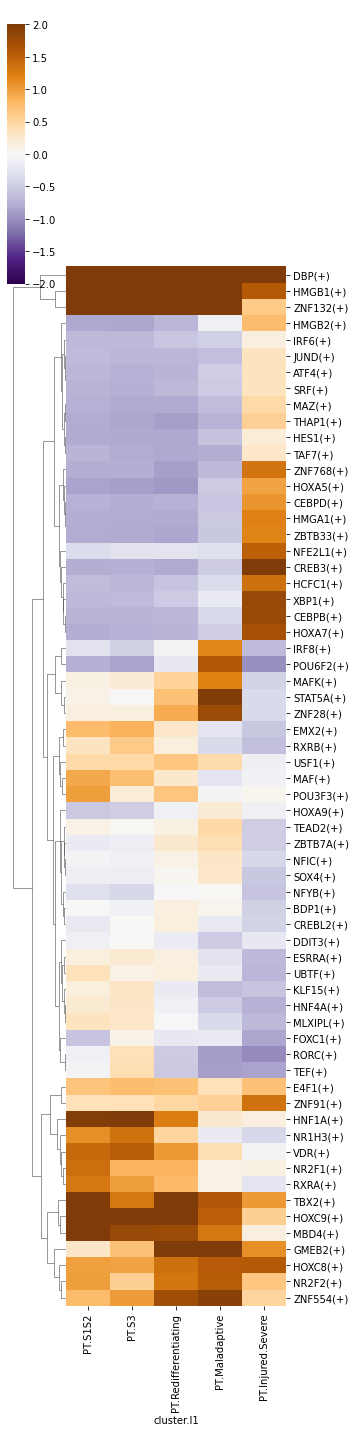

In [26]:
plot1=sns.clustermap(auc_mtx3_norm2,cmap="PuOr_r",figsize=(5,20),col_cluster=False,vmin=-2,vmax=2,
                    method="complete",metric="euclidean")
#plt.savefig("PT_regulon_AUC_selected.png", dpi=600, bbox_inches = "tight")

In [24]:
rss_cellType = regulon_specificity_scores(auc_mtx, celltype['cluster.l1'] )
rss_cellType.head(6)

,ATF4(+),BDP1(+),BHLHE40(+),CEBPB(+),CEBPD(+),CEBPG(+),CREB3(+),CREBL2(+),DBP(+),DDIT3(+),...,XBP1(+),YBX1(+),ZBTB14(+),ZBTB33(+),ZBTB7A(+),ZNF132(+),ZNF28(+),ZNF554(+),ZNF768(+),ZNF91(+)
PT.Injured.Severe,0.412587,0.333777,0.316901,0.625001,0.590736,0.368814,0.642048,0.314214,0.396397,0.336055,...,0.590881,0.298615,0.290694,0.615181,0.333916,0.251769,0.291648,0.322680,0.532687,0.420209
PT.Redifferentiating,0.214778,0.400609,0.353511,0.256347,0.266598,0.396639,0.225755,0.361001,0.364511,0.329555,...,0.277648,0.341215,0.305299,0.260143,0.416395,0.371271,0.407710,0.399009,0.256837,0.361475
PT.Maladaptive,0.218281,0.273608,0.250859,0.234248,0.233089,0.285698,0.219832,0.245566,0.261603,0.222911,...,0.248013,0.240085,0.236323,0.236082,0.296096,0.260614,0.330178,0.283683,0.217194,0.258053
PT.S1S2,0.197088,0.399266,0.383137,0.226336,0.228982,0.325518,0.207028,0.320235,0.372279,0.342608,...,0.228367,0.348295,0.333952,0.233033,0.366186,0.424570,0.348853,0.355593,0.261588,0.376292
PT.S3,0.188919,0.310643,0.349372,0.210237,0.207549,0.257397,0.201853,0.303134,0.305003,0.309572,...,0.215507,0.257119,0.259648,0.207697,0.301816,0.347495,0.296340,0.310591,0.212592,0.302593


In [26]:
topreg = []
for i,c in enumerate(cats):
    topreg.extend(
        list(rss_cellType.T[c].sort_values(ascending=False)[:10].index)
    )
topreg = list(set(topreg))
auc_mtx_Z = pd.DataFrame( index=auc_mtx.index )
for col in list(auc_mtx.columns):
    auc_mtx_Z[ col ] = ( auc_mtx[col] - auc_mtx[col].mean()) / auc_mtx[col].std(ddof=0)

In [27]:
auc_mtx_Z=auc_mtx_Z.loc[celltype.index.tolist()]

In [28]:
def palplot(pal, names, colors=None, size=1):
    n = len(pal)
    f, ax = plt.subplots(1, 1, figsize=(n * size, size))
    ax.imshow(np.arange(n).reshape(1, n),
              cmap=matplotlib.colors.ListedColormap(list(pal)),
              interpolation="nearest", aspect="auto")
    ax.set_xticks(np.arange(n) - .5)
    ax.set_yticks([-.5, .5])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    colors = n * ['k'] if colors is None else colors
    for idx, (name, color) in enumerate(zip(names, colors)):
        ax.text(0.0+idx, 0.0, name, color=color, horizontalalignment='center', verticalalignment='center')
    return f

In [29]:
colors = sns.color_palette('Accent',n_colors=len(cats) )
colorsd = dict( zip( ["PT.S1S2","PT.S3","PT.Redifferentiating","PT.Maladaptive","PT.Injured.Severe"], colors ))
colormap = [ colorsd[x] for x in celltype['cluster.l1'] ]

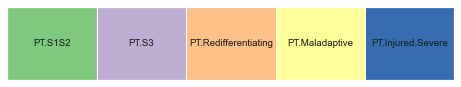

In [36]:
sns.set()
sns.set(font_scale=0.8)

fig = palplot( colors, ["PT.S1S2","PT.S3","PT.Redifferentiating","PT.Maladaptive","PT.Injured.Severe"], size=1.3)
plt.savefig("PT_heatmap_legend.png", dpi=600, bbox_inches = "tight")


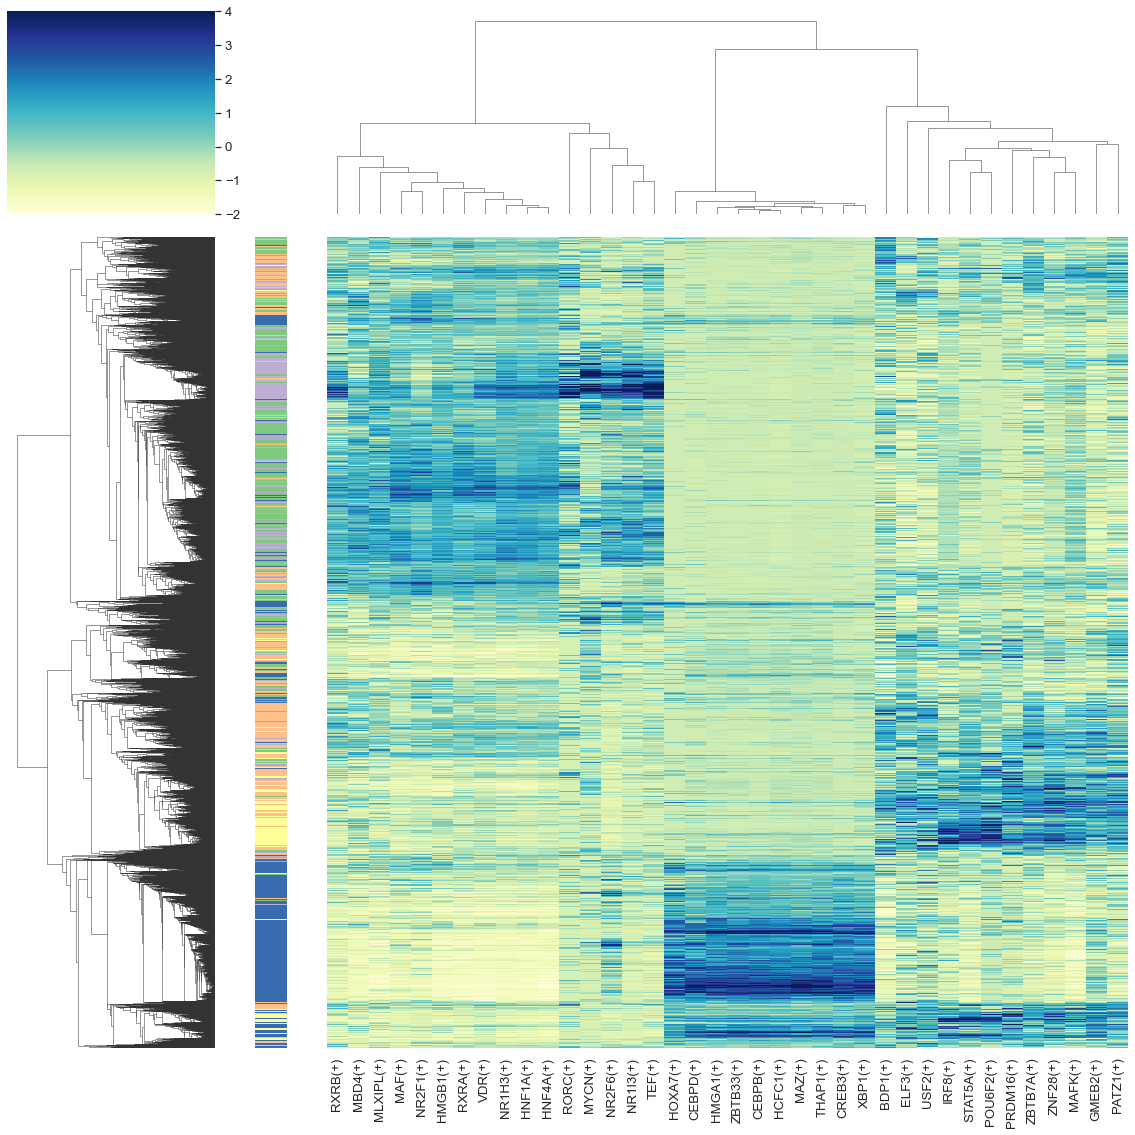

In [39]:
sns.set(font_scale=1.2)
g = sns.clustermap(auc_mtx_Z[topreg], annot=False,  square=False,  linecolor='gray',
    yticklabels=False, xticklabels=True, vmin=-2, vmax=4, row_colors=colormap,
    cmap="YlGnBu", figsize=(16,16),method="average",metric="cosine")
g.cax.set_visible(True)
g.ax_heatmap.set_ylabel('')
g.ax_heatmap.set_xlabel('')
plt.savefig("PT_heatmap_top10.png", dpi=600, bbox_inches = "tight")